<a href="https://colab.research.google.com/github/flybiubiu/cs231n/blob/master/knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/nholmber/google-colab-cs231n.git

Cloning into 'google-colab-cs231n'...
remote: Enumerating objects: 109, done.
remote: Total 109 (delta 0), reused 0 (delta 0), pack-reused 109
Receiving objects: 100% (109/109), 5.07 MiB | 7.63 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [0]:
%cd google-colab-cs231n/assignment1

/content/google-colab-cs231n/assignment1


In [0]:
!pip install imageio

In [0]:
%cd cs231n/datasets/
!./get_datasets.sh

/content/google-colab-cs231n/assignment1/cs231n/datasets
--2019-09-22 05:10:08--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  31.7MB/s    in 5.8s    

2019-09-22 05:10:14 (28.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [0]:
%cd ../..
!ls

/content/google-colab-cs231n/assignment1
collectSubmission.sh  README.md		    svm.ipynb
cs231n		      requirements.txt	    two_layer_net_colab.ipynb
features.ipynb	      setup_googlecloud.sh  two_layer_net.ipynb
frameworkpython       softmax.ipynb
knn.ipynb	      start_ipython_osx.sh


In [0]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

In [0]:
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print ('Training data shape: ', X_train.shape)
print ('Training labels shape: ',y_train.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


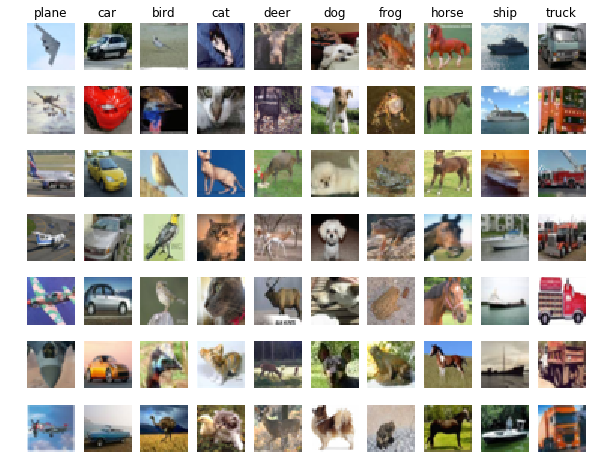

In [0]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
  idxs = np.flatnonzero(y_train == y)
  idxs = np.random.choice(idxs, samples_per_class, replace=False)
  for i, idx in enumerate(idxs):
    plt_idx = i * num_classes + y + 1
    plt.subplot(samples_per_class, num_classes, plt_idx)
    plt.imshow(X_train[idx].astype('uint8'))
    plt.axis('off')
    if i == 0:
      plt.title(cls)
plt.show()

In [0]:
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_mask = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print (X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [0]:
class KNearestNeighbor(object):
  def __init__(self):
    pass
  def train(self, X, y):
    self.X_train = X
    self.y_train = y
  def predict(self, X, k = 1, num_loops = 0):
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)
    return self.predict_labels(dists, k = k)
  def compute_distances_two_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        dists[i, j] = np.linalg.norm(X[i] - self.X_train[j])
    return dists
  def compute_distances_one_loop(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      dists[i] = np.linalg.norm(X[i] - self.X_train, axis = 1)
    return dists
  def compute_distances_no_loops(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    x2 = np.sum(X ** 2,axis = 1).reshape((num_test, 1))
    y2 = np.sum(self.X_train ** 2, axis = 1).reshape((1, num_train))
    xy = -2 * np.matmul(X, self.X_train.T)
    dists = np.sqrt(x2 + xy + y2)
    return dists
  def predict_labels(self, dists, k = 1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test, dtype = int)
    for i in range(num_test):
      closest_x = np.argsort(dists[i])[:k]
      closest_y = [self.y_train[val] for val in closest_x]
      labels, count = np.unique(closest_y, return_counts = True)
      y_pred[i] = labels[np.argmax(count)]
    return y_pred

In [0]:
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [0]:
dists = classifier.compute_distances_two_loops(X_test)
print (dists.shape)

(500, 5000)


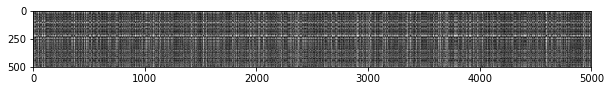

In [0]:
plt.imshow(dists, interpolation='none')
plt.show()

In [0]:
y_test_pred = classifier.predict_labels(dists, k = 1)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


In [0]:
y_test_pred = classifier.predict_labels(dists, k = 5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d /%d correct => accuracy: %f' % (num_correct, num_correct, accuracy))

Got 139 /139 correct => accuracy: 0.278000


In [0]:
dists_one = classifier.compute_distances_one_loop(X_test)
difference = np.linalg.norm(dists - dists_one, ord='fro')

In [0]:
print ('Difference was: %f' % (difference, ))
if difference < 0.001:
  print ('Good!')
else:
  print ('Oops!')

Difference was: 0.000000
Good!


In [0]:
dists_two = classifier.compute_distances_no_loops(X_test)
difference = np.linalg.norm(dists - dists_two, ord='fro')
print ('Difference was: %f' %  (difference, ))
if difference < 0.001:
  print ('Good!')
else:
  print ('Oops!')

Difference was: 0.000000
Good!


In [0]:
def time_function(f, *args):
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print ('Two loop version took %f seconds' % two_loop_time)
one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print ('One loop version took %f seconds' % one_loop_time)
no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print ('No loop version took %f seconds' % no_loop_time)

Two loop version took 33.508858 seconds
One loop version took 50.075183 seconds
No loop version took 0.659737 seconds


In [0]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
X_train_folds = []
y_train_folds = []
pass
avg_size = int(X_train.shape[0] / num_folds)
for i in range(num_folds):
  X_train_folds.append(X_train[i * avg_size : (i + 1) * avg_size])
  y_train_folds.append(y_train[i * avg_size : (i + 1) * avg_size])
k_to_accuracies = {}
pass
for k in k_choices:
  accuracies = []
  print (k)
  for i in range(num_folds):
    X_train_cv = np.vstack(X_train_folds[0:i] + X_train_folds[i+1:])
    y_train_cv = np.hstack(y_train_folds[0:i] + y_train_folds[i+1:]) 
    X_valid_cv = X_train_folds[i]
    y_valid_cv = y_train_folds[i]
    classifier.train(X_train_cv, y_train_cv)
    dists = classifier.compute_distances_no_loops(X_valid_cv)
    accuracy = float(np.sum(classifier.predict_labels(dists, k) == y_valid_cv)) / y_valid_cv.shape[0]
    accuracies.append(accuracy)
  k_to_accuracies[k] = accuracies
for k in sorted(k_to_accuracies):
  for accuracy in k_to_accuracies[k]:
    print ('k = %d, accracy = %f' % (k, accuracy))

1
3
5
8
10
12
15
20
50
100
k = 1, accracy = 0.263000
k = 1, accracy = 0.257000
k = 1, accracy = 0.264000
k = 1, accracy = 0.278000
k = 1, accracy = 0.266000
k = 3, accracy = 0.239000
k = 3, accracy = 0.249000
k = 3, accracy = 0.240000
k = 3, accracy = 0.266000
k = 3, accracy = 0.254000
k = 5, accracy = 0.248000
k = 5, accracy = 0.266000
k = 5, accracy = 0.280000
k = 5, accracy = 0.292000
k = 5, accracy = 0.280000
k = 8, accracy = 0.262000
k = 8, accracy = 0.282000
k = 8, accracy = 0.273000
k = 8, accracy = 0.290000
k = 8, accracy = 0.273000
k = 10, accracy = 0.265000
k = 10, accracy = 0.296000
k = 10, accracy = 0.276000
k = 10, accracy = 0.284000
k = 10, accracy = 0.280000
k = 12, accracy = 0.260000
k = 12, accracy = 0.295000
k = 12, accracy = 0.279000
k = 12, accracy = 0.283000
k = 12, accracy = 0.280000
k = 15, accracy = 0.252000
k = 15, accracy = 0.289000
k = 15, accracy = 0.278000
k = 15, accracy = 0.282000
k = 15, accracy = 0.274000
k = 20, accracy = 0.270000
k = 20, accracy = 0.2

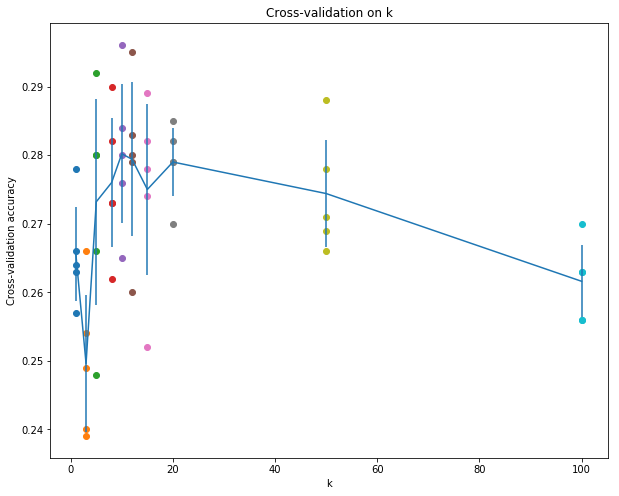

In [0]:
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)
accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [0]:
best_k = 10
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print ('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
